**Project 🚧**

One of the main pain point that AT&T users are facing is constant exposure to SPAM messages.

AT&T has been able to manually flag spam messages for a time, but they are looking for an automated way of detecting spams to protect their users.

**Goals 🎯**

Your goal is to build a spam detector, that can automatically flag spams as they come based solely on the sms' content.

# Basic information

In [538]:
import pandas as pd
import numpy as np
import chardet
from IPython.display import clear_output
import warnings
warnings.filterwarnings("ignore")

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import spacy
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
import tiktoken
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchinfo import summary

from transformers import AutoTokenizer
from transformers import DataCollatorWithPadding
from transformers import TrainingArguments
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from datasets import Dataset as dset

device = torch.cuda.current_device() if torch.cuda.is_available() else "cpu"
device_name = torch.cuda.get_device_name(0)

print("Device:", device)
print("CUDA availability:", torch.cuda.is_available())
print("GPU amount:", torch.cuda.device_count())
print("GPU name:", torch.cuda.get_device_name(0))

Device: 0
CUDA availability: True
GPU amount: 1
GPU name: NVIDIA GeForce RTX 4060 Laptop GPU


In [539]:
csv_path = "spam.csv"

with open(csv_path, "rb") as original_file:
    data_to_decode = original_file.read()
encoding_result = chardet.detect(data_to_decode)
detected_encoding = encoding_result["encoding"]
print(detected_encoding)

Windows-1252


In [540]:
df = pd.read_csv(csv_path, encoding='Windows-1252')
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [541]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


### Content preview

In [542]:
for val in df['Unnamed: 2']:
    if not pd.isna(val):
        print(val)

 PO Box 5249
 the person is definitely special for u..... But if the person is so special
 HOWU DOIN? FOUNDURSELF A JOBYET SAUSAGE?LOVE JEN XXX\""
 wanted to say hi. HI!!!\" Stop? Send STOP to 62468"
this wont even start........ Datz confidence.."
 PO Box 5249
GN
.;-):-D"
just been in bedbut mite go 2 thepub l8tr if uwana mt up?loads a luv Jenxxx.\""
 bt not his girlfrnd... G o o d n i g h t . . .@"
 I'll come up"
 don't miss ur best life for anything... Gud nyt..."
 just as a shop has to give a guarantee on what they sell. B. G."
 But at d end my love compromised me for everything:-(\".. Gud mornin:-)"
 the toughest is acting Happy with all unspoken pain inside..\""
 smoke hella weed\""
\" not \"what i need to do.\""
JUST GOT PAYED2DAY & I HAVBEEN GIVEN Aå£50 PAY RISE 4MY WORK & HAVEBEEN MADE PRESCHOOLCO-ORDINATOR 2I AM FEELINGOOD LUV\""
 justthought iåÕd sayhey! how u doin?nearly the endof me wk offdam nevamind!We will have 2Hook up sn if uwant m8? loveJen x.\""
JUST REALLYNEED 2DOCD

In [543]:
for val in df['Unnamed: 3']:
    if not pd.isna(val):
        print(val)

 MK17 92H. 450Ppw 16"
 why to miss them
 MK17 92H. 450Ppw 16"
GE
U NO THECD ISV.IMPORTANT TOME 4 2MORO\""
i wil tolerat.bcs ur my someone..... But
 ILLSPEAK 2 U2MORO WEN IM NOT ASLEEP...\""
whoever is the KING\"!... Gud nyt"
 TX 4 FONIN HON
 \"OH No! COMPETITION\". Who knew
GE
IåÕL CALL U\""


In [544]:
for val in df['Unnamed: 4']:
    if not pd.isna(val):
        print(val)

 just Keep-in-touch\" gdeve.."
GNT:-)"
 Never comfort me with a lie\" gud ni8 and sweet dreams"
 CALL 2MWEN IM BK FRMCLOUD 9! J X\""
 one day these two will become FREINDS FOREVER!"
GNT:-)"


# Basic cleaning

We will try three methods of addressing our project, which may involve more steps in preparing our data. For now the basics:

In [545]:
df_v1 = df.copy(deep=True)

# Replacing NA to ease concatenating messages
for i in range(2,5,1):
    df_v1[f'Unnamed: {i}'] = df_v1[f'Unnamed: {i}'].fillna("")

df_v1['v2']=pd.concat([df_v1['v2'],df_v1['Unnamed: 2'],df_v1['Unnamed: 3'],df_v1['Unnamed: 4']], ignore_index=True)

df_v1.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",,,
1,ham,Ok lar... Joking wif u oni...,,,
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,,,
3,ham,U dun say so early hor... U c already then say...,,,
4,ham,"Nah I don't think he goes to usf, he lives aro...",,,


In [546]:
# Columns renaming & dropping now empty ones, then binary association ham/spam
df_v1 = df_v1[['v1', 'v2']].set_axis(['label', 'text'], axis=1)

df_v1['label'] = df_v1['label'].map({'ham':0,'spam':1})

df_v1.head()

,label,text
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [547]:
spam_share = (df_v1['label'].mean())*100
print(f'Spam share in the corpus: {spam_share:,.2f} %')

Spam share in the corpus: 13.41 %


Now we'll produce three copies for our coming works:

In [548]:
df_baseline = df_v1.copy(deep=True)
df_baselemma = df_v1.copy(deep=True)
df_transformers = df_v1.copy(deep=True)

# Baseline model

A model doesn't have to be complicated. Let's try a very simple one with the least prep work!

### Preparations

We'll jump straight into encoding tokens on our texts with openAI's cl100k:

In [549]:
tokenizer = tiktoken.get_encoding("cl100k_base")

def encode_texts(texts):
    return [tokenizer.encode(text) for text in texts]

baseline_train_tokens = encode_texts(df_baseline['text'])
baseline_train_tokens[0][:10]

[11087, 3156, 16422, 647, 1486, 11, 14599, 497, 16528, 1193]

For a view of our tokens' distribution:

avg seq len : 22.48707824838478
max seq len : 259
min seq len : 1


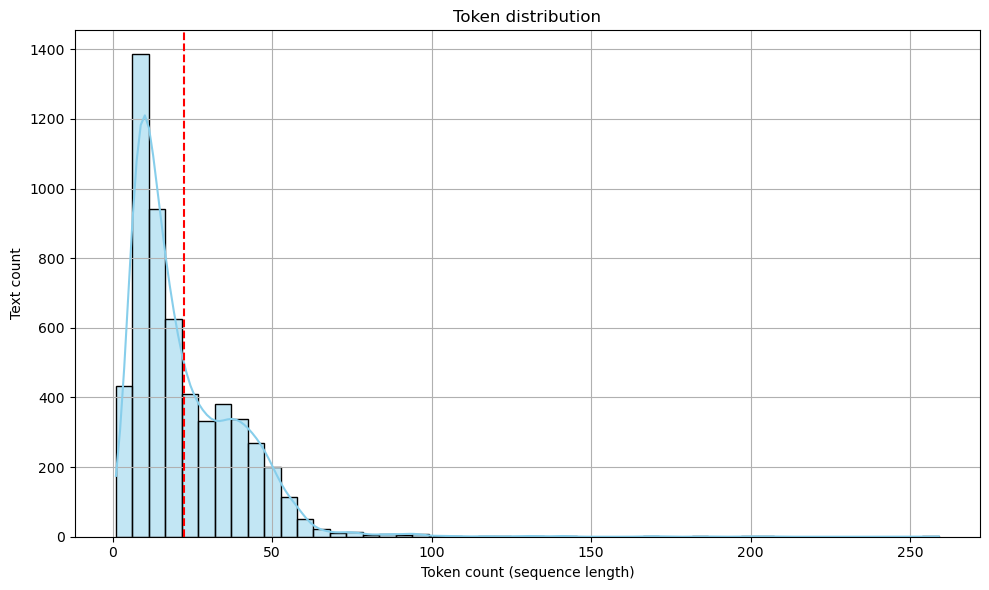

In [550]:
baseline_seq_length = [len(seq) for seq in baseline_train_tokens]

print("avg seq len :", np.mean(baseline_seq_length))
print("max seq len :", np.max(baseline_seq_length))
print("min seq len :", np.min(baseline_seq_length))

plt.figure(figsize=(10, 6))
sns.histplot(baseline_seq_length, bins=50, kde=True, color='skyblue')
plt.title("Token distribution")
plt.xlabel("Token count (sequence length)")
plt.ylabel("Text count")
plt.axvline(x=np.mean(baseline_seq_length), color='red', linestyle='--', label='mean')
plt.grid(True)
plt.tight_layout()
plt.show()

We can see extremely few rows are past the 100 tokens. Still, we don't necessarily want to throw away our longer messages so we'll use padding, to make sure each message has the same length for processing by our model!

### Preprocessing

In [551]:
def pad_sequences(sequences, max_length=200):
    return [seq[:max_length] + [0] * (max_length - len(seq)) for seq in sequences]

baseline_train_tokens = pad_sequences(baseline_train_tokens)

Let's wrap up the preprocessing then:

In [552]:
class SPAMDataset(Dataset):
    """
    A custom class to convert text data (already tokenized) and their corresponding labels
    into a PyTorch Dataset object, which can be easily loaded into a DataLoader.
    """

    def __init__(self, texts, labels):
        """
        Initializes the dataset by storing texts and labels as PyTorch tensors.
        - texts (list or numpy array): Tokenized text data, where each text has been converted
                                       into a sequence of word indices (integer tokens).
        - labels (list or numpy array): The corresponding labels for each text .
        """
        # Convert text sequences to a PyTorch tensor (long type since they are indices)
        self.texts = torch.tensor(texts, dtype=torch.long)
        # Convert labels to a PyTorch tensor (float32 for compatibility with loss functions)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        """
        Required with PyTorch datasets so DataLoader can determine how many batches it needs.
        """
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Retrieves a single data point (text and label) from the dataset based on an index.
        - idx (int): Index of the sample to retrieve.

        Returns a tuple containing:
            - self.texts[idx]: The tokenized text at index `idx`.
            - self.labels[idx]: The corresponding label for that text.
        """
        return self.texts[idx], self.labels[idx]

# Example usage: Creating a dataset instance
df_dataset = SPAMDataset(baseline_train_tokens, df_baseline['label'])

# Split dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(df_dataset))
val_size = len(df_dataset) - train_size
train_dataset, val_dataset = random_split(df_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [553]:
text, label = next(iter(train_loader))
print(label)
print(text)

tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])
tensor([[ 2822,  1120,  3708,  ...,     0,     0,     0],
        [   40,   656,  1440,  ...,     0,     0,     0],
        [10156, 20910,    11,  ...,     0,     0,     0],
        ...,
        [   38,  2114,  5871,  ...,     0,     0,     0],
        [51290,    11,   358,  ...,     0,     0,     0],
        [ 7927,  7446,  1495,  ...,     0,     0,     0]])


We still need to enable our model to make sense on our behalf, with embedding, of the tensors running through it:

In [554]:
vocab_size = tokenizer.n_vocab

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_class)

    def forward(self, text):
        embedded = self.embedding(text)
        pooled = self.pooling(embedded.permute(0, 2, 1)).squeeze(2)
        return torch.sigmoid(self.fc(pooled))

model = TextClassifier(vocab_size=vocab_size,
                      embed_dim=16,
                      num_class=1)

In [555]:
print(model, "\n")
summary(model, input_data=text)

TextClassifier(
  (embedding): Embedding(100277, 16, padding_idx=0)
  (pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=16, out_features=1, bias=True)
) 



Layer (type:depth-idx)                   Output Shape              Param #
TextClassifier                           [32, 1]                   --
├─Embedding: 1-1                         [32, 200, 16]             1,604,432
├─AdaptiveAvgPool1d: 1-2                 [32, 16, 1]               --
├─Linear: 1-3                            [32, 1]                   17
Total params: 1,604,449
Trainable params: 1,604,449
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 51.34
Input size (MB): 0.05
Forward/backward pass size (MB): 0.82
Params size (MB): 6.42
Estimated Total Size (MB): 7.29

### Training

In [556]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, val_loader, criterion, optimizer, epochs=200, device=device):
    """
    Function to train a PyTorch model with training and validation datasets.

    Parameters:
    model: The neural network model to train.
    train_loader: DataLoader for the training dataset.
    val_loader: DataLoader for the validation dataset.
    criterion: Loss function (e.g., Binary Cross Entropy for classification).
    optimizer: Optimization algorithm (e.g., Adam, SGD).
    epochs: Number of training epochs (default=100).

    Returns:
    history: Dictionary containing loss and accuracy for both training and validation.
    """

    # Dictionary to store training & validation loss and accuracy over epochs
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}


    for epoch in range(epochs):  # Loop over the number of epochs
        model.train()  # Set model to training mode
        total_loss, correct = 0, 0  # Initialize total loss and correct predictions

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            model = model.to(device)
            optimizer.zero_grad()  # Reset gradients before each batch
            outputs = model(inputs).squeeze()  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation (compute gradients)
            optimizer.step()  # Update model parameters

            total_loss += loss.item()  # Accumulate batch loss
            #probs = torch.sigmoid(outputs)
            # preds = (probs > 0.5).float()
            # correct += (preds == labels).sum().item()
            correct += ((outputs > 0.5) == labels).sum().item()  # Count correct predictions


        # Compute average loss and accuracy for training
        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)


        # Validation phase (without gradient computation)
        model.eval()  # Set model to evaluation mode
        val_loss, val_correct = 0, 0
        with torch.no_grad():  # No need to compute gradients during validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                model = model.to(device)
                outputs = model(inputs).squeeze()  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                val_loss += loss.item()  # Accumulate validation loss
                # val_probs = torch.sigmoid(outputs)
                # val_preds = (val_probs > 0.5).float()
                # val_correct += (val_preds == labels).sum().item()
                val_correct += ((outputs > 0.5) == labels).sum().item()  # Count correct predictions

        # Compute average loss and accuracy for validation
        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)

        # Store metrics in history dictionary
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)

        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history  # Return training history

history = train(model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                epochs=60, 
                device=device)

Epoch [1/60], Loss: 0.6443, Acc: 0.8636, Val Loss: 0.6157, Val Acc: 0.8753
Epoch [2/60], Loss: 0.5920, Acc: 0.8636, Val Loss: 0.5608, Val Acc: 0.8753
Epoch [3/60], Loss: 0.5362, Acc: 0.8636, Val Loss: 0.5020, Val Acc: 0.8753
Epoch [4/60], Loss: 0.4771, Acc: 0.8636, Val Loss: 0.4441, Val Acc: 0.8762
Epoch [5/60], Loss: 0.4194, Acc: 0.8696, Val Loss: 0.3897, Val Acc: 0.8834
Epoch [6/60], Loss: 0.3668, Acc: 0.8876, Val Loss: 0.3408, Val Acc: 0.8987
Epoch [7/60], Loss: 0.3187, Acc: 0.9123, Val Loss: 0.2979, Val Acc: 0.9193
Epoch [8/60], Loss: 0.2791, Acc: 0.9329, Val Loss: 0.2607, Val Acc: 0.9336
Epoch [9/60], Loss: 0.2420, Acc: 0.9444, Val Loss: 0.2294, Val Acc: 0.9543
Epoch [10/60], Loss: 0.2131, Acc: 0.9547, Val Loss: 0.2031, Val Acc: 0.9605
Epoch [11/60], Loss: 0.1877, Acc: 0.9625, Val Loss: 0.1813, Val Acc: 0.9677
Epoch [12/60], Loss: 0.1675, Acc: 0.9681, Val Loss: 0.1629, Val Acc: 0.9704
Epoch [13/60], Loss: 0.1512, Acc: 0.9729, Val Loss: 0.1474, Val Acc: 0.9749
Epoch [14/60], Loss: 

Let's extract this model's metrics:

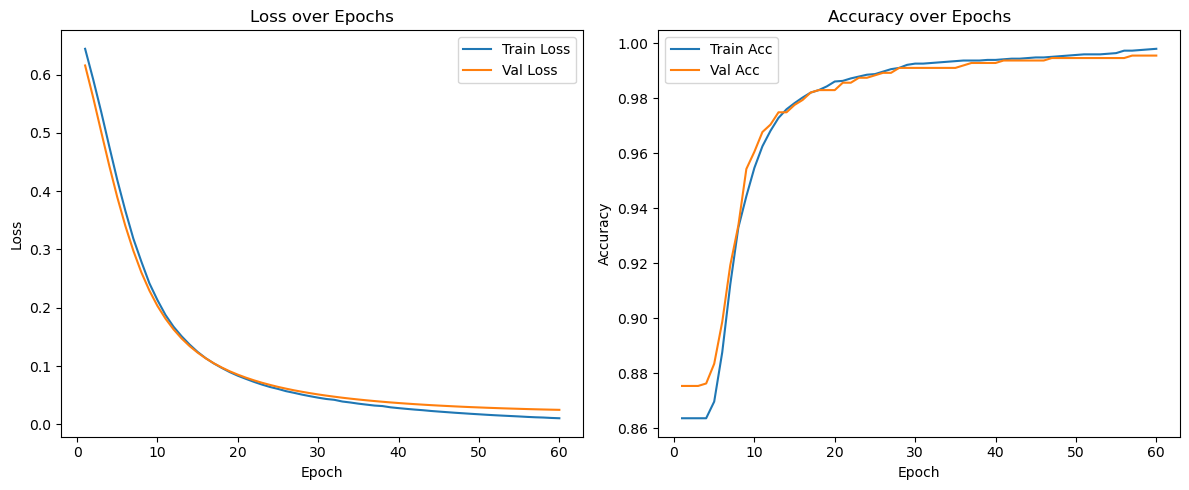

In [557]:
epochs = range(1, len(history['loss'])+1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) #loss
plt.plot(epochs, history['loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2) #accuracy
plt.plot(epochs, history['accuracy'], label='Train Acc')
plt.plot(epochs, history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### Mistakes analysis

In [558]:
def evaluate_worst_predictions(model, dataloader, tokenizer, device=device):
    model.eval()  # Set model to evaluation mode
    
    all_predictions = []
    all_labels = []
    all_errors = []
    all_inputs = []

    with torch.no_grad():  # No gradients needed during evaluation
        for batch in dataloader:
            inputs, labels = batch  # Assuming (inputs, labels) in DataLoader
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            model.to(device)
            outputs = model(inputs)

            # Convert outputs to predicted class (for classification)
            if outputs.shape[-1] > 1:  # Multi-class classification
                preds = torch.argmax(outputs, dim=1)
                errors = (preds != labels).float()  # Misclassified observations
            else:  # Regression
                preds = outputs.squeeze()
                errors = torch.abs(preds - labels)  # Absolute error

            # Save results
            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_errors.extend(errors.cpu().numpy())
            all_inputs.extend(inputs.cpu().numpy())

    # Retrieve as dataframe
    df_results = pd.DataFrame({
        "True_Label": all_labels,
        "Predicted": all_predictions,
        "Error": all_errors,
        "Inputs": all_inputs,
        "Text" : [tokenizer.decode(input) for input in all_inputs]
    })

    df_results_sorted = df_results.sort_values(by="Error", ascending=False)

    return df_results_sorted

# Example usage:
worst_predictions_val = evaluate_worst_predictions(model, val_loader, tokenizer, device=device)
worst_predictions_train = evaluate_worst_predictions(model, train_loader, tokenizer, device=device)

##### Metrics & matrices

First for our training set:

In [559]:
true_labels = worst_predictions_train['True_Label']
predicted_labels = np.round(worst_predictions_train['Predicted'])
print(classification_report(true_labels, predicted_labels))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3849
         1.0       1.00      0.99      0.99       608

    accuracy                           1.00      4457
   macro avg       1.00      0.99      1.00      4457
weighted avg       1.00      1.00      1.00      4457



In [560]:
confusion_train = pd.DataFrame(confusion_matrix(predicted_labels, true_labels),
             columns=["pred_HAM","pred_SPAM"], index=["true_HAM","true_SPAM"])
px.imshow(confusion_train, text_auto=True)

Then for the validation set:

In [561]:
true_labels_val = worst_predictions_val['True_Label']
predicted_labels_val = np.round(worst_predictions_val['Predicted'])
print(classification_report(true_labels_val, predicted_labels_val))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       976
         1.0       0.99      0.97      0.98       139

    accuracy                           1.00      1115
   macro avg       0.99      0.99      0.99      1115
weighted avg       1.00      1.00      1.00      1115



In [562]:
confusion_val = pd.DataFrame(confusion_matrix(predicted_labels_val, true_labels_val),
             columns=["pred_HAM","pred_SPAM"], index=["true_HAM","true_SPAM"])
px.imshow(confusion_val, text_auto=True)

##### Observations

Now for a precise view of what was mistakenly classified:

In [162]:
worst_predictions_train.head()

,True_Label,Predicted,Error,Inputs,Text
1134,1.0,0.010848,0.989152,"[5519, 499, 3596, 5406, 430, 994, 499, 2351, 1...","Do you ever notice that when you're driving, a..."
447,1.0,0.123113,0.876887,"[25821, 602, 617, 2834, 3243, 287, 1396, 220, ...",Money i have won wining number 946 wot do i do...
2159,1.0,0.148084,0.851916,"[29089, 499, 1093, 311, 1518, 856, 20572, 2206...",Would you like to see my XXX pics they are so ...
2800,1.0,0.188812,0.811188,"[19701, 358, 13942, 701, 1650, 1095, 596, 3137...",Sorry I missed your call let's talk when you h...
3874,1.0,0.230648,0.769352,"[7131, 499, 6865, 922, 279, 502, 1144, 12792, ...","Did you hear about the new \Divorce Barbie\""? ..."


In [110]:
worst_predictions_val.head()

,True_Label,Predicted,Error,Inputs,Text
686,1.0,0.000005,0.999995,"[5519, 499, 3596, 5406, 430, 994, 499, 2351, 1...","Do you ever notice that when you're driving, a..."
902,1.0,0.000398,0.999602,"[43, 40777, 706, 2646, 1027, 420, 1790, 2523, ...",LIFE has never been this much fun and great un...
13,1.0,0.000859,0.999141,"[5519, 499, 13383, 430, 304, 922, 220, 1272, 1...","Do you realize that in about 40 years, we'll h..."
166,1.0,0.008903,0.991097,"[25821, 602, 617, 2834, 3243, 287, 1396, 220, ...",Money i have won wining number 946 wot do i do...
94,1.0,0.010038,0.989962,"[12174, 856, 10087, 0, 358, 3077, 1766, 701, 1...",Oh my god! I've found your number again! I'm s...


### Deductions

Although our model is performing surprisingly well, its few mistakes seem tied to a frequent issue met by NLP: irony.

A very positive vocabulary with a completely different meaning (illustrated by scores) tends to mislead our model, albeit rarely.

To explain it with numbers:
* What we are trying to predict is whether the passing text message is a spam or not.
* A false positive means a harmless message was treated as spam; conversely, a false negative means a spam managed to get through our filter.
* 4 of our 979 actual "ham" messages were intercepted by our model, while a single spam out of 136 got through it.
* Using percentages, 0.4% of harmless messages were blocked for 0.7% of spams missed.
* Over the 1115 messages, this represents a total of 0.3% of false positives and less than 0.1% of false negatives.

Still, for what little work it went through in preprocessing & training, this baseline model is performing really well!

# Lemmatized baseline

Let's try something a little more fancy by performing the lemmatization of our text - in other words, by reducing words to their essence to help our model!

### Preparations

Although the steps are similar to the baseline model, we're adding lemmatization:

In [29]:
df_baselemma['text'] = df_baselemma['text'].replace(r' +', ' ').str.strip()

nlp = spacy.load("en_core_web_sm")

def lemmatize_and_clean(text):
    doc = nlp(text)
    lemmas = [
        token.lemma_
        for token in doc
        if token.lemma_ not in STOP_WORDS and token.text not in STOP_WORDS and not token.is_punct
    ]
    return " ".join(lemmas)

df_baselemma['text'] = df_baselemma['text'].apply(lemmatize_and_clean)

**Warning:** lemmatization should be performed **after** tokenization for computation efficiency. It may still work this way but isn't optimal.

We've kept it as-is since it was a debate while working on it. Regardless, on such a small dataset the difference was minimal.

In [30]:
tokenizer = tiktoken.get_encoding("cl100k_base")

def encode_texts(texts):
    return [tokenizer.encode(text) for text in texts]

baselemma_train_tokens = encode_texts(df_baselemma['text'])
baselemma_train_tokens[0][:10]

[87977, 647, 1486, 14599, 2561, 10077, 285, 308, 2294, 1917]

avg seq len : 12.562096195262024
max seq len : 164
min seq len : 0


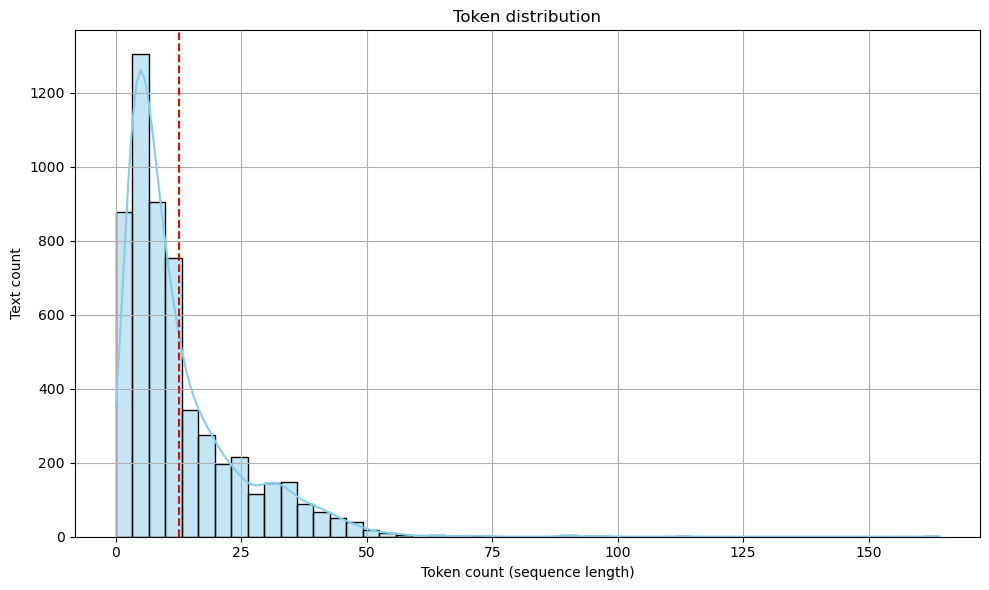

In [31]:
seq_length = [len(seq) for seq in baselemma_train_tokens]

print("avg seq len :", np.mean(seq_length))
print("max seq len :", np.max(seq_length))
print("min seq len :", np.min(seq_length))

plt.figure(figsize=(10, 6))
sns.histplot(seq_length, bins=50, kde=True, color='skyblue')
plt.title("Token distribution")
plt.xlabel("Token count (sequence length)")
plt.ylabel("Text count")
plt.axvline(x=np.mean(seq_length), color='red', linestyle='--', label='mean')
plt.grid(True)
plt.tight_layout()
plt.show()

### Preprocessing

In [32]:
def pad_sequences(sequences, max_length=150):
    return [seq[:max_length] + [0] * (max_length - len(seq)) for seq in sequences]

baselemma_train_tokens = pad_sequences(baselemma_train_tokens)

In [33]:
class SPAMDataset(Dataset):
    """
    A custom class to convert text data (already tokenized) and their corresponding labels
    into a PyTorch Dataset object, which can be easily loaded into a DataLoader.
    """

    def __init__(self, texts, labels):
        """
        Initializes the dataset by storing texts and labels as PyTorch tensors.
        - texts (list or numpy array): Tokenized text data, where each text has been converted
                                       into a sequence of word indices (integer tokens).
        - labels (list or numpy array): The corresponding labels for each text .
        """
        # Convert text sequences to a PyTorch tensor (long type since they are indices)
        self.texts = torch.tensor(texts, dtype=torch.long)
        # Convert labels to a PyTorch tensor (float32 for compatibility with loss functions)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        """
        Required with PyTorch datasets so DataLoader can determine how many batches it needs.
        """
        return len(self.texts)

    def __getitem__(self, idx):
        """
        Retrieves a single data point (text and label) from the dataset based on an index.
        - idx (int): Index of the sample to retrieve.

        Returns a tuple containing:
            - self.texts[idx]: The tokenized text at index `idx`.
            - self.labels[idx]: The corresponding label for that text.
        """
        return self.texts[idx], self.labels[idx]

# Example usage: Creating a dataset instance
df_dataset = SPAMDataset(baselemma_train_tokens, df_baseline['label'])

# Split dataset into training (80%) and validation (20%)
train_size = int(0.8 * len(df_dataset))
val_size = len(df_dataset) - train_size
train_dataset, val_dataset = random_split(df_dataset, [train_size, val_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [34]:
text, label = next(iter(train_loader))
print(label)
print(text)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
        0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])
tensor([[27963, 11734, 24898,  ...,     0,     0,     0],
        [ 2203,   408,   502,  ...,     0,     0,     0],
        [   40,  3067,     0,  ...,     0,     0,     0],
        ...,
        [94317,  5246,  1695,  ...,     0,     0,     0],
        [ 2063,  1427, 10269,  ...,     0,     0,     0],
        [ 9410,   426, 28594,  ...,     0,     0,     0]])


In [35]:
vocab_size = tokenizer.n_vocab

class TextClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.pooling = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(embed_dim, num_class)

    def forward(self, text):
        embedded = self.embedding(text)
        pooled = self.pooling(embedded.permute(0, 2, 1)).squeeze(2)
        return torch.sigmoid(self.fc(pooled))

model = TextClassifier(vocab_size=vocab_size,
                      embed_dim=16,
                      num_class=1)

In [36]:
print(model, "\n")
summary(model, input_data=text)

TextClassifier(
  (embedding): Embedding(100277, 16, padding_idx=0)
  (pooling): AdaptiveAvgPool1d(output_size=1)
  (fc): Linear(in_features=16, out_features=1, bias=True)
) 



Layer (type:depth-idx)                   Output Shape              Param #
TextClassifier                           [32, 1]                   --
├─Embedding: 1-1                         [32, 150, 16]             1,604,432
├─AdaptiveAvgPool1d: 1-2                 [32, 16, 1]               --
├─Linear: 1-3                            [32, 1]                   17
Total params: 1,604,449
Trainable params: 1,604,449
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 51.34
Input size (MB): 0.04
Forward/backward pass size (MB): 0.61
Params size (MB): 6.42
Estimated Total Size (MB): 7.07

### Training

In [37]:
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def train(model, train_loader, val_loader, criterion, optimizer, epochs=200, device=device):
    """
    Function to train a PyTorch model with training and validation datasets.

    Parameters:
    model: The neural network model to train.
    train_loader: DataLoader for the training dataset.
    val_loader: DataLoader for the validation dataset.
    criterion: Loss function (e.g., Binary Cross Entropy for classification).
    optimizer: Optimization algorithm (e.g., Adam, SGD).
    epochs: Number of training epochs (default=100).

    Returns:
    history: Dictionary containing loss and accuracy for both training and validation.
    """

    # Dictionary to store training & validation loss and accuracy over epochs
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}


    for epoch in range(epochs):  # Loop over the number of epochs
        model.train()  # Set model to training mode
        total_loss, correct = 0, 0  # Initialize total loss and correct predictions

        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            model = model.to(device)
            optimizer.zero_grad()  # Reset gradients before each batch
            outputs = model(inputs).squeeze()  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backpropagation (compute gradients)
            optimizer.step()  # Update model parameters

            total_loss += loss.item()  # Accumulate batch loss
            #probs = torch.sigmoid(outputs)
            # preds = (probs > 0.5).float()
            # correct += (preds == labels).sum().item()
            correct += ((outputs > 0.5) == labels).sum().item()  # Count correct predictions


        # Compute average loss and accuracy for training
        train_loss = total_loss / len(train_loader)
        train_acc = correct / len(train_loader.dataset)


        # Validation phase (without gradient computation)
        model.eval()  # Set model to evaluation mode
        val_loss, val_correct = 0, 0
        with torch.no_grad():  # No need to compute gradients during validation
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                model = model.to(device)
                outputs = model(inputs).squeeze()  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                val_loss += loss.item()  # Accumulate validation loss
                # val_probs = torch.sigmoid(outputs)
                # val_preds = (val_probs > 0.5).float()
                # val_correct += (val_preds == labels).sum().item()
                val_correct += ((outputs > 0.5) == labels).sum().item()  # Count correct predictions

        # Compute average loss and accuracy for validation
        val_loss /= len(val_loader)
        val_acc = val_correct / len(val_loader.dataset)

        # Store metrics in history dictionary
        history['loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['accuracy'].append(train_acc)
        history['val_accuracy'].append(val_acc)

        # Print training progress
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history  # Return training history

history = train(model,
                train_loader=train_loader,
                val_loader=val_loader,
                criterion=criterion,
                optimizer=optimizer,
                epochs=60, 
                device=device)

Epoch [1/60], Loss: 0.7131, Acc: 0.2315, Val Loss: 0.6847, Val Acc: 0.8395
Epoch [2/60], Loss: 0.6561, Acc: 0.8986, Val Loss: 0.6284, Val Acc: 0.8762
Epoch [3/60], Loss: 0.5970, Acc: 0.8921, Val Loss: 0.5684, Val Acc: 0.8861
Epoch [4/60], Loss: 0.5334, Acc: 0.9154, Val Loss: 0.5057, Val Acc: 0.9211
Epoch [5/60], Loss: 0.4685, Acc: 0.9417, Val Loss: 0.4435, Val Acc: 0.9453
Epoch [6/60], Loss: 0.4076, Acc: 0.9554, Val Loss: 0.3866, Val Acc: 0.9587
Epoch [7/60], Loss: 0.3519, Acc: 0.9652, Val Loss: 0.3370, Val Acc: 0.9623
Epoch [8/60], Loss: 0.3047, Acc: 0.9704, Val Loss: 0.2951, Val Acc: 0.9623
Epoch [9/60], Loss: 0.2654, Acc: 0.9733, Val Loss: 0.2604, Val Acc: 0.9659
Epoch [10/60], Loss: 0.2327, Acc: 0.9755, Val Loss: 0.2315, Val Acc: 0.9668
Epoch [11/60], Loss: 0.2059, Acc: 0.9782, Val Loss: 0.2078, Val Acc: 0.9704
Epoch [12/60], Loss: 0.1833, Acc: 0.9796, Val Loss: 0.1879, Val Acc: 0.9722
Epoch [13/60], Loss: 0.1647, Acc: 0.9818, Val Loss: 0.1712, Val Acc: 0.9722
Epoch [14/60], Loss: 

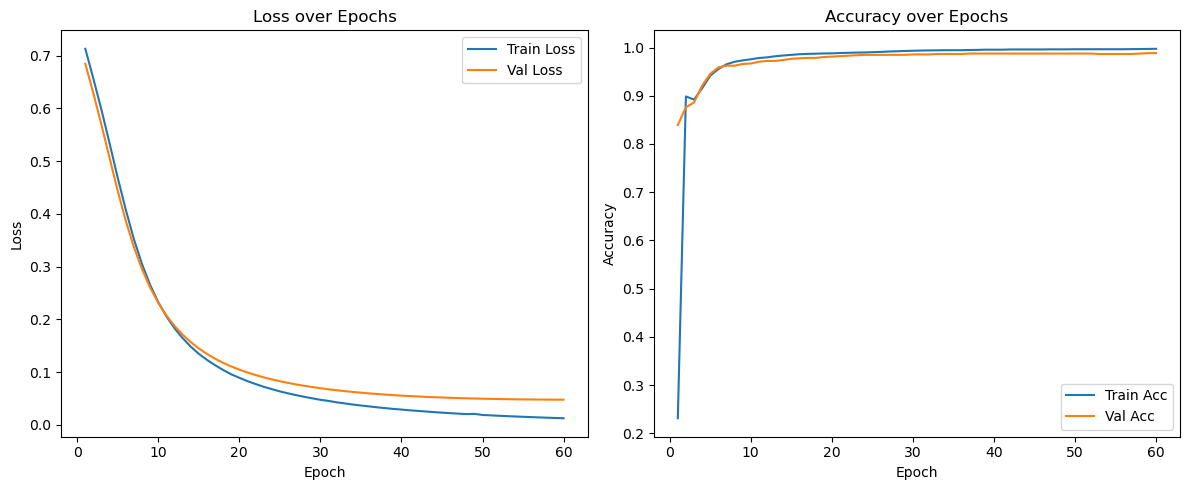

In [38]:
epochs = range(1, len(history['loss'])+1)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1) #loss
plt.plot(epochs, history['loss'], label='Train Loss')
plt.plot(epochs, history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2) #accuracy
plt.plot(epochs, history['accuracy'], label='Train Acc')
plt.plot(epochs, history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

### Mistakes analysis

In [39]:
def evaluate_worst_predictions(model, dataloader, tokenizer, device=device):
    model.eval()  # Set model to evaluation mode
    
    all_predictions = []
    all_labels = []
    all_errors = []
    all_inputs = []

    with torch.no_grad():  # No gradients needed during evaluation
        for batch in dataloader:
            inputs, labels = batch  # Assuming (inputs, labels) in DataLoader
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            model.to(device)
            outputs = model(inputs)

            # Convert outputs to predicted class (for classification)
            if outputs.shape[-1] > 1:  # Multi-class classification
                preds = torch.argmax(outputs, dim=1)
                errors = (preds != labels).float()  # Misclassified observations
            else:  # Regression
                preds = outputs.squeeze()
                errors = torch.abs(preds - labels)  # Absolute error

            # Save results
            all_predictions.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_errors.extend(errors.cpu().numpy())
            all_inputs.extend(inputs.cpu().numpy())

    # Retrieve as dataframe
    df_results = pd.DataFrame({
        "True_Label": all_labels,
        "Predicted": all_predictions,
        "Error": all_errors,
        "Inputs": all_inputs,
        "Text" : [tokenizer.decode(input) for input in all_inputs]
    })

    df_results_sorted = df_results.sort_values(by="Error", ascending=False)

    return df_results_sorted

# Example usage:
worst_predictions_val = evaluate_worst_predictions(model, val_loader, tokenizer, device=device)
worst_predictions_train = evaluate_worst_predictions(model, train_loader, tokenizer, device=device)

##### Metrics & matrices

First on training:

In [40]:
true_labels = worst_predictions_train['True_Label']
predicted_labels = np.round(worst_predictions_train['Predicted'])
print(classification_report(true_labels, predicted_labels))

confusion_train = pd.DataFrame(confusion_matrix(predicted_labels, true_labels),
             columns=["pred_HAM","pred_SPAM"], index=["true_HAM","true_SPAM"])
px.imshow(confusion_train, text_auto=True)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3863
         1.0       1.00      0.98      0.99       594

    accuracy                           1.00      4457
   macro avg       1.00      0.99      0.99      4457
weighted avg       1.00      1.00      1.00      4457



Then on validation:

In [41]:
true_labels_val = worst_predictions_val['True_Label']
predicted_labels_val = np.round(worst_predictions_val['Predicted'])
print(classification_report(true_labels_val, predicted_labels_val))

confusion_val = pd.DataFrame(confusion_matrix(predicted_labels_val, true_labels_val),
             columns=["pred_HAM","pred_SPAM"], index=["true_HAM","true_SPAM"])
px.imshow(confusion_val, text_auto=True)

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99       962
         1.0       0.99      0.93      0.96       153

    accuracy                           0.99      1115
   macro avg       0.99      0.96      0.97      1115
weighted avg       0.99      0.99      0.99      1115



##### Observations

To zoom in on what our model mispredicted:

In [42]:
worst_predictions_train.head()

,True_Label,Predicted,Error,Inputs,Text
2976,1.0,0.012253,0.987747,"[15339, 15627, 273, 3432, 358, 3021, 6369, 337...",hello darle today I love chat tell look like s...
4003,1.0,0.039851,0.960149,"[14789, 2523, 2294, 2586, 9615, 3361, 358, 108...",life fun great come truly special I forget enj...
884,1.0,0.042687,0.957313,"[2063, 2697, 892, 1716, 16984, 6453, 32639, 13...",come little time child afraid dark teenager wa...
2645,1.0,0.139557,0.860443,"[24467, 6678, 6435, 43358, 6678, 5043, 893, 18...",notice drive slow idiot drive fast maniac!!!!!...
4221,1.0,0.198612,0.801388,"[12723, 27520, 3446, 86109, 7416, 3868, 0, 0, ...",filthy story GIRLS wait!!!!!!!!!!!!!!!!!!!!!!!...


In [43]:
worst_predictions_val.head()

,True_Label,Predicted,Error,Inputs,Text
932,1.0,0.000222,0.999778,"[68697, 358, 3194, 1095, 3137, 892, 358, 220, ...",sorry I miss let talk time I 07090201529!!!!!!...
1027,0.0,0.999750,0.999750,"[16, 23182, 6187, 284, 2360, 19150, 220, 16, 5...",1apple Day = No Doctor 1Tulsi Leaf Day = No Ca...
422,1.0,0.007808,0.992192,"[8110, 553, 220, 1272, 1060, 16579, 2362, 1724...",realize 40 year thousand old lady run tattoo!!...
856,1.0,0.008963,0.991037,"[66665, 1645, 7160, 22534, 24, 1772, 24748, 73...",SMS ac sun0819 post hello:\you cool!!!!!!!!!!!...
137,1.0,0.012391,0.987609,"[1045, 1212, 3708, 1495, 3137, 10775, 9063, 20...",date start send text talk sport radio week con...


### Deductions

Despite excellent performances as well, our lemmatized model is slightly worse. Irony still is an issue; a lot of similarities with our baseline model.

In numbers, with the same assumptions as the previous baseline:
* 11 out of 971 "ham" messages were mistakenly intercepted, representing 1.1% of false positives.
* 2 out of 114 spams got through, meaning 1.4% of missed content.
* Overall, this can be translated as 1% of false positives and 0.2% of false negatives.

We may infer lemmatization lost part of the meaning in some messages, "diluting" the harm (or lack of) and confusing our model in filtering messages.

We'll stick with the regular baseline for now!

# Transformers model

We'll go much faster with this one using the transformers library and Google's bert.

### Preparations & preprocessing

Since our baseline model with the least preparations performed better, we'll follow the same idea here by simply encoding tokens:

In [45]:
dataset_dftrans = dset.from_pandas(df_transformers)
dataset_dftrans

Dataset({
    features: ['label', 'text'],
    num_rows: 5572
})

In [46]:
split_dataset = dataset_dftrans.train_test_split(test_size=0.2, seed=42)

train_dataset = split_dataset['train']
val_dataset = split_dataset['test']

print(f"Train set : {len(train_dataset)} samples")
print(f"Validation set : {len(val_dataset)} samples")

Train set : 4457 samples
Validation set : 1115 samples


In [47]:
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(example):
    return tokenizer(example["text"], truncation=True, padding=True)

tok_df_train_dtrans = train_dataset.map(tokenize_function, batched=True)
tok_df_val_trans = val_dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 1115/1115 [00:00<00:00, 12176.36 examples/s]


In [48]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

### Training

In [ ]:
# Careful with size: this will write 5 Go of data to monitor the model!
training_args = TrainingArguments("test-trainer",report_to="none")

In [50]:
model_trans = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
trainer = Trainer(
    model_trans,
    training_args,
    train_dataset= tok_df_train_dtrans,
    eval_dataset= tok_df_val_trans,
    data_collator=data_collator,
    processing_class=tokenizer,
)

In [52]:
trainer.train()

Step,Training Loss
500,0.085800
1000,0.035700
1500,0.015500


TrainOutput(global_step=1674, training_loss=0.04159572403633181, metrics={'train_runtime': 389.8378, 'train_samples_per_second': 34.299, 'train_steps_per_second': 4.294, 'total_flos': 1620040031726580.0, 'train_loss': 0.04159572403633181, 'epoch': 3.0})

### Results, metrics & matrices

In [53]:
predictions = trainer.predict(tok_df_val_trans)

In [54]:
preds_trans = np.argmax(predictions.predictions, axis=-1)

In [ ]:
true_labels_trans = tok_df_val_trans["label"]
print(classification_report(true_labels_trans, preds_trans))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       970
           1       0.98      0.96      0.97       145

    accuracy                           0.99      1115
   macro avg       0.99      0.98      0.98      1115
weighted avg       0.99      0.99      0.99      1115



In [ ]:
confusion = pd.DataFrame(confusion_matrix(preds_trans, true_labels_trans),
             columns=["pred_HAM","pred_SPAM"], index=["true_HAM","true_SPAM"])
px.imshow(confusion, text_auto=True)

##### Observations

Although very close in performances, openAI's cl100k seems to perform better for our spam detection than Google's bert does.

In numbers:
* 0.6% of harmless messages were intercepted,
* 2% of spams got through,
* This last model produces 0.5% of false positives and 0.2% of false negatives.

We'll still stick with our very first, unrefined model!